In [1]:
# default inputs
import tellurium as te
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
showOriginalModelString = True

In [7]:
if showOriginalModelString:
    model = te.loadSBMLModel("Mg_M.xml")
    modelStr = model.getAntimony()
    print(modelStr)
    

// Created by libAntimony v2.12.0
model *pad_mac()

  // Compartments and Species:
  compartment unnamed;
  species deg in unnamed, V165a in unnamed, IFNG in unnamed, IFNGR_JAK in unnamed;
  species IFNG_R_JAK in unnamed, pIFNG_R_JAK in unnamed, STAT1 in unnamed;
  species pIFNG_R_JAK_STAT1 in unnamed, pSTAT1 in unnamed, pSTAT1D in unnamed;
  species pSTAT1D_n in unnamed, STAT1D_n in unnamed, STAT1_n in unnamed, $SOCS1_prod in unnamed;
  species SOCS1 in unnamed, IFNG_R_JAK_SOCS1 in unnamed, IFNG_R_lyso in unnamed;
  species SOCS1_JAK in unnamed, IRF9 in unnamed, IRF9_n in unnamed, pSTAT1D_IRF9 in unnamed;
  species pSTAT1D_IRF9_n in unnamed, $CXCL10_prod in unnamed, SOCS3 in unnamed;
  species IFNG_R_JAK_SOCS3 in unnamed, SOCS3_JAK in unnamed, $SOCS3_prod in unnamed;
  species IL4 in unnamed, IL4R_JAK in unnamed, IL4_R_JAK in unnamed, pIL4_R_JAK in unnamed;
  species STAT6 in unnamed, pIL4_R_JAK_STAT6 in unnamed, pSTAT6 in unnamed;
  species pSTAT6D in unnamed, pSTAT6D_n in unnamed, S

In [3]:
def run(model,selections, duration):
    model.integrator.absolute_tolerance = 1e-9
    model.integrator.relatice_tolerance = 1e-9
    results = model.simulate(start = 0, end = duration,steps = duration,
                             selections = selections)
    return results
def modify(modelStr,replacements):
    for key,value in replacements.items():
        modelStr = modelStr.replace(key,value)
    return modelStr
def merge(modelStr,sub_model):
    rr = modelStr.split('\nend\n\npad_mac')
    combined = rr[0]+sub_model+'\nend\n\npad_mac is "pad mac"\n'
    return combined

In [4]:
# replacements = {
#     '$ikk_prod => IKK; k191*ikk_prod':'NEMO_IKK + Mg => Mg_NEMO + IKK; k302*Mg*NEMO_IKK - k303*IKK - k304*Mg_NEMO',
#     'IKK + pTAK1 => pIKK + pTAK1; k189*IKK*pTAK1^2': 'IKK + pTAK1 => pIKK + pTAK1; k305*IKK*pTAK1^2',
#     'IKK + O2_aPHD => deg + O2_aPHD;  k192*IKK*O2_aPHD^2': 'IKK + O2_aPHD => deg + O2_aPHD; k306*IKK*O2_aPHD^2',
#     'pIKK => IKK; k190*pIKK': 'pIKK => IKK; k307*pIKK'
# }
replacements = {
    '$ikk_prod => IKK; k191*ikk_prod':'NEMO_IKK + Mg => Mg_NEMO + IKK; k302*Mg*NEMO_IKK- k303*IKK - k304*Mg_NEMO'
}

extra_additions = """
    #// Mg initial condition and diffusion
    Mg_e_mM = 0.8; #mM
    Mg_e = Mg_e_mM*Mg_copy;
    Mg = 0.8*Mg_copy ; # internal/physiological Mg
    $Mg_e -> Mg; k301*(Mg_e - Mg) ; # Mg diffuses from extra- to intracellular space through345 TRPM7  
    Mg_copy = 1000;k301 = .1;
    
    #// params related to the NEMO_IKK + Mg interaction
    Mg_NEMO = 1000;
    k302=0.01; k303 = 0.01; k304=0.01;
    
    #// NEMO_IKK production and degrdation
    $NEMO_IKK_prod => NEMO_IKK; k308-k310*NEMO_IKK; #production
    Mg_NEMO -> deg; k309*Mg_NEMO; # degradation
    NEMO_IKK_prod = 1; NEMO_IKK = 1000;k310=100;k309=.1;k308=100;
"""
originalModel = te.loadSBMLModel("Zhao_2021.xml")
originalModelStr = originalModel.getAntimony ()
modified_model = modify(originalModelStr,replacements)
combined = merge(modified_model,extra_additions)
combined = te.loada(combined)
combined.exportToSBML('Mg_M.xml')


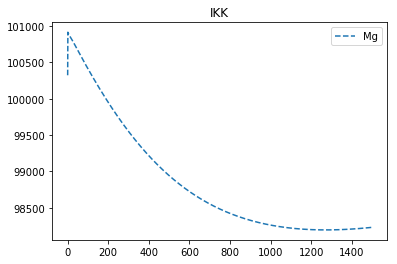

In [5]:
def initial_conditions(model,keys,values):
    for i in range(len(keys)):
        free_param_name = keys[i]
        model[free_param_name] = values[i]

def run(model,targets, duration):
    model.integrator.absolute_tolerance = 1e-9
    model.integrator.relatice_tolerance = 1e-9
    results = model.simulate(start = 0, end = duration,steps = duration,
                             selections = targets)
    return results
targets = ['IKK']
model = combined
model.reset()
initial_conditions(model,['k301','k302','Mg_e','NEMO_IKK'],[100,100,600,600])
results = run(model,targets,1500)
for tag in targets:
    fig = plt.figure()
    plt.plot(results[tag],label = 'Mg',linestyle = '--')
    plt.legend()
    plt.title(tag)

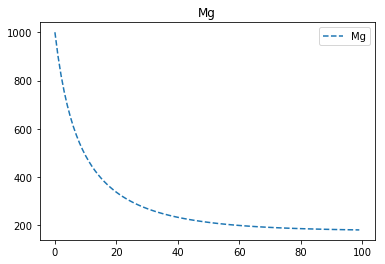

In [6]:
test = """
    NEMO_IKK + Mg => Mg_NEMO + IKK; k302*Mg*NEMO_IKK- k303*IKK - k304*Mg_NEMO;
    #NEMO_IKK + Mg => Mg_NEMO + IKK; k302*Mg*NEMO_IKK;
    NEMO_IKK = 1000; Mg=1000; Mg_NEMO= 1000; IKK = 800; 
    k302=.00011;k303=.001;k304=.001;
"""
testModel = te.loada(test)
targets = ['Mg']
results = testModel.simulate(0,100,100,selections = ['TIME']+targets)
for tag in targets:
    fig = plt.figure()
    plt.plot(results[tag],label = 'Mg',linestyle = '--')
    plt.legend()
    plt.title(tag)